<a href="https://colab.research.google.com/github/minseok40231/2025.LLM/blob/main/202021004%EA%B9%80%EB%AF%BC%EC%84%9D%20%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
loss is 0.0030075334943830967
loss is 0.0033197784796357155
loss is 0.0034888379741460085
loss is 0.003068165620788932
loss is 0.003101601032540202
loss is 0.003644601907581091
loss is 0.003443192457780242
loss is 0.003126581432297826
loss is 0.0034395798575133085
loss is 0.0033693581353873014
loss is 0.0034187184646725655
loss is 0.003100734669715166
loss is 0.0032932383473962545
loss is 0.0034046811051666737
loss is 0.00368458847515285
loss is 0.003414366627112031
loss is 0.003795749507844448
loss is 0.003977019339799881
loss is 0.0030917769763618708
loss is 0.0038121885154396296
loss is 0.0038404790684580803
loss is 0.003433136036619544
loss is 0.0036550050135701895
loss is 0.0034187473356723785
loss is 0.003891358617693186
loss is 0.0031620298977941275
loss is 0.0033625327050685883
loss is 0.0031654175836592913
loss is 0.003530437359586358
loss is 0.0032832417637109756
loss is 0.0034199014771729708
loss is 0.0033233759459108114
loss is 0.00352684

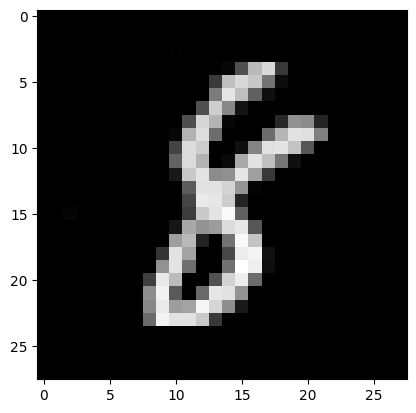

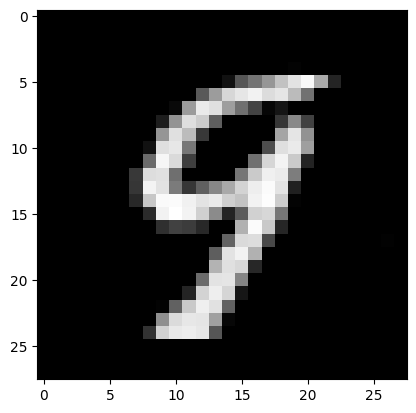

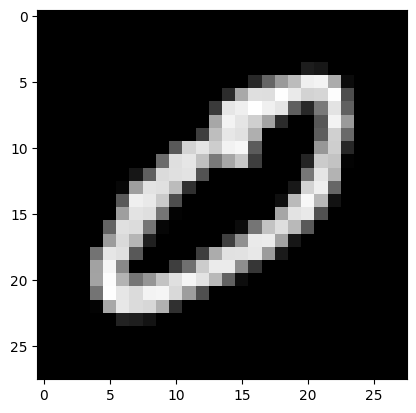

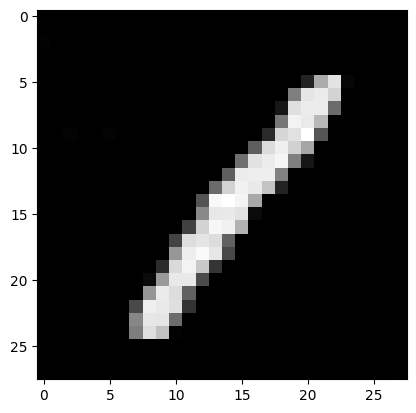

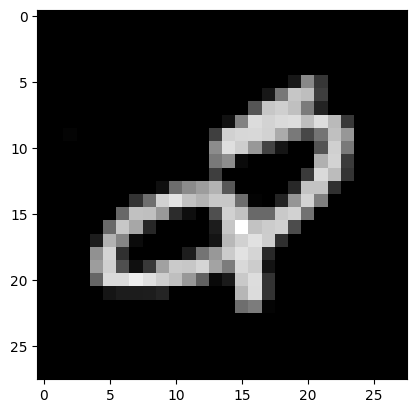

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),   # 16 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1),  # 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,padding=1),  # 64 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)              # 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),  # 128 x 14 x 14

            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding=1),  # 256 x 7 x 7
            nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,2,1,1), # 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,64,3,1,1), # 64 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64,16,3,1,1), # 16 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,3,2,1,1), # 1 x 28 x 28
            nn.ReLU()
        )

    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

mnist_train = dset.MNIST("./data/MNIST", train=True,
                         transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./data/MNIST", train=False,
                        transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 100
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

num_epoch = 10
Learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)
parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=Learning_rate)

for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        z = encoder(image)
        output = decoder(z)
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        print("loss is", loss.cpu().item())

for i in range(1):
    for j,[image, label] in enumerate(test_loader):
        image = image.to(device)
        z = encoder(image)
        output = decoder(z)

        loss = loss_func(output,image)
        if j % 10 == 0:
            print(loss)
print("loss is", loss.cpu().item())

out_img = torch.squeeze(output.cpu().data)
print(out_img.size())
for i in range(5):
    plt.show()
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()